# Plotting Tools

In [1]:
import os
import csv
import pickle
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
import datetime


# Plot Armball tests 

In [2]:
log_dir = "./log" 
FIGSIZE = (15,9)
LW = 3

# Comparison

In [3]:
def plot_performance(means,stds,X=None,names=None,title="",ylabel="performance", minimum = -np.inf, maximum=np.inf,
                     log=False, double =False, xlabel="learning episodes"):
    if names is None:
        names = [str(j) for j in range(len(means))]
    compute_X = (X is None)
    if len(means)<5:
        ncol = [1,1,2,2,2][len(means)] 
    else:
        ncol = len(means)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    colors = ['crimson','royalblue','forestgreen','darkorange','orchid']
    handles = []
    for i in range(len(means)):
        if (double and i>=len(means)/2):
            linestyle = ":"
            color = colors[i%(len(means)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.array(means[i]), np.array(stds[i])
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
        ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
        plt.plot(X, mean_p_std, color=color, alpha=0.2)
        plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        if (X[1]-X[0])!=(X[-1]-X[-2]):
            plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2, loc="center left",ncol=ncol,bbox_to_anchor=(0., 1.07))
    plt.show()

# My tensorflow

In [17]:
def plot_episodes_errors(subdirs,names,func,data):
    data = ['trainingfinal.pk','eval.pk'][data]
    traj_means, trans_means = [], []
    traj_stds, trans_stds = [], []
    for param in subdirs:
        traj_errors = []
        trans_errors = []
        for subdir in param:
            f = open(subdir+data,'br')
            (pred_traj,pred_trans,true_traj,_,_) = pickle.load(f)
            true_traj = true_traj[:,:,:31]
            f.close()

            traj_errors.append(func(np.linalg.norm( pred_traj-true_traj, axis=(2)), axis=1))
            trans_errors.append(func(np.linalg.norm( pred_trans-true_traj, axis=(2)), axis=1))
        traj_means.append(np.mean(traj_errors, axis=0))
        trans_means.append(np.mean(trans_errors, axis=0))
        trans_stds.append(np.std(trans_errors, axis=0))
        traj_stds.append(np.std(traj_errors, axis=0))

    means = traj_means+trans_means
    stds = traj_stds +trans_stds
    
    names = [name+' traj' for name in names]+ [name+' trans' for name in names]
    plot_performance(means,stds,log=True,names=names,ylabel="trajectory prediction error",xlabel="evaluation episode")
    
    fig,axarr = plt.subplots(2,1, sharex=True,figsize=FIGSIZE)

    plt.subplot(211)
    plt.title("trajectory error")
    plt.boxplot(traj_means)
    plt.yscale('log')
    plt.xticks([i for i in range(1,1+len(names)//2)],names[:len(names)//2])
    
    plt.subplot(212)
    plt.boxplot(trans_means)
    plt.title("transition error")
    plt.ylabel("Error")
    plt.yscale('log')
    
    plt.xticks([i for i in range(1,1+len(names)//2)],names[:len(names)//2])

In [30]:
def plot_traj(subdir,j,Tmax,pred_type, eval_type):
    if eval_type:
        file = "evalfinal.pk"
    else:
        file = "trainingfinal.pk"
    f = open(subdir+file,'br')
    (pred_traj,pred_trans,true_traj,error_traj,error_trans) = pickle.load(f)
    if pred_type:
        pred = pred_traj
        print(error_traj[j])
    else:
        pred = pred_trans
        print(error_trans[j])
    f.close()
    fig, ax = plt.subplots(figsize=FIGSIZE)
    
    plt.scatter(true_traj[j,-1,3], true_traj[j,-1,4],color='royalblue',marker='s',zorder=4,s=100)
    plt.scatter(true_traj[j,-1,8], true_traj[j,-1,9],color='green',marker='D',zorder=4,s=100)   
    plt.scatter(true_traj[j,-1,12], true_traj[j,-1,13],color='crimson',marker='D',zorder=4,s=100)   
    
    plt.scatter(pred[j,-1,3], pred[j,-1,4],color='blue',marker='s',zorder=4,s=100)
    plt.scatter(pred[j,-1,8], pred[j,-1,9],color='lime',marker='D',zorder=4,s=100)
    plt.scatter(pred[j,-1,12], pred[j,-1,13],color='red',marker='D',zorder=4,s=100)
    
    plt.plot(pred[j,:Tmax,3], pred[j,:Tmax,4],lw=LW,ls=":",zorder=3,c="royalblue",label="hand")
    plt.plot(true_traj[j,:Tmax,3], true_traj[j,:Tmax,4],lw=LW,ls="-",c="royalblue")
    
    plt.plot(pred[j,:Tmax,8], pred[j,:Tmax,9],lw=LW,ls=":",zorder=3,c="darkgreen",label="left")
    plt.plot(true_traj[j,:Tmax,8], true_traj[j,:Tmax,9],lw=LW,ls="-",c="darkgreen")
    
    plt.plot(pred[j,:Tmax,12], pred[j,:Tmax,13],lw=LW,ls=":",zorder=3,c="crimson",label="right")
    plt.plot(true_traj[j,:Tmax,12], true_traj[j,:Tmax,13],lw=LW,ls="-",c="crimson")    
    
    plt.legend()

In [19]:
def plot_pred(subdir,data, j, Tmax, Pmax):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    data = ['trainingfinal.pk','evalfinal.pk'][data]
    f = open(subdir+data,'br')
    (pred_traj,pred_trans,true_traj,_,_) = pickle.load(f)
    if Pmax<5:
        colors = ['crimson','royalblue','darkgreen','orange','cyan']
    else:
        colors = np.random.random((Pmax,3))
    for p in range(Pmax):
        plt.plot(true_traj[j,:Tmax+1,p]-true_traj[j,0,p], c=colors[p], label=str(p))
        plt.plot(pred_traj[j,:Tmax+1,p]-pred_traj[j,0,p], ls=":", c=colors[p])
        #plt.plot(true_traj[j,:Tmax+1,p]-pred_traj[j,:Tmax+1,p], c=colors[p], label=str(p))
    plt.legend()


In [20]:
def plot_errors(subdirs,names,func,data):
    data = ['trainingfinal.pk','eval.pk'][data]
    traj_means, trans_means = [], []
    traj_stds, trans_stds = [], []
    for param in subdirs:
        traj_errors = []
        trans_errors = []
        for subdir in param:
            f = open(subdir+data,'br')
            (pred_traj,pred_trans,true_traj,_,_) = pickle.load(f)
            true_traj = true_traj[:,:,:31]
            f.close()
            #traj_errors.append(func(np.linalg.norm( pred_traj-true_traj, axis=(2)), axis=1))
            trans_errors.append(func(np.linalg.norm( pred_trans-true_traj, axis=(2), ord=1)/31, axis=1))
       # traj_means.append(np.mean(traj_errors, axis=0))
        trans_means.append(np.mean(trans_errors, axis=0))
        trans_stds.append(np.std(trans_errors, axis=0))
       #traj_stds.append(np.std(traj_errors, axis=0))

    means = traj_means+trans_means
    stds = traj_stds +trans_stds
    
    names = [name+' traj' for name in names]+ [name+' trans' for name in names]
    plot_performance(means,stds,log=False,names=names,ylabel="trajectory prediction error",
                     xlabel="evaluation episode")

In [24]:
test = "/home/tim/Documents/stage-m2/tf_test/log/2019-04-29 09:19:21.160025/"


subdirs = [[test]]
names = ["norm","unnorm"]

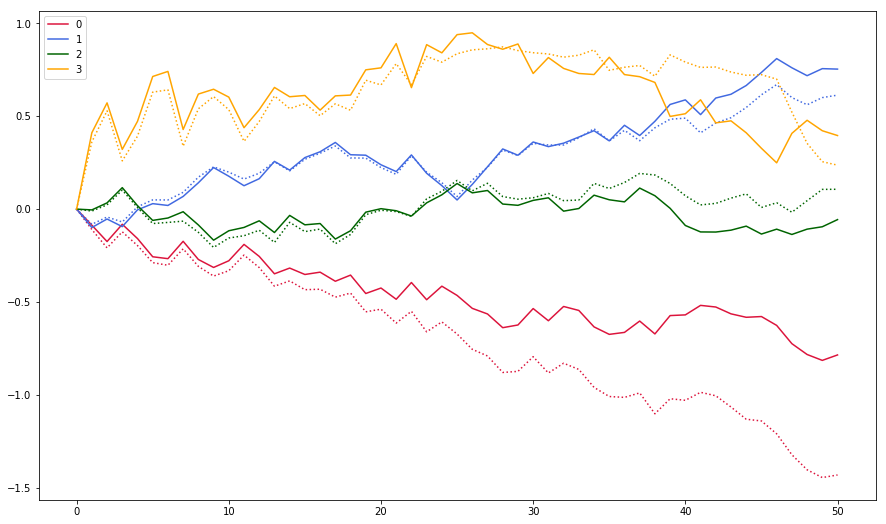

In [25]:
plot_pred(subdirs[0][0],data=1, j=1, Tmax=51, Pmax=4)

In [26]:
plot_errors(subdirs,names,np.mean,0)

ValueError: operands could not be broadcast together with shapes (190,51,18) (190,51,31) 

3.579412069047033


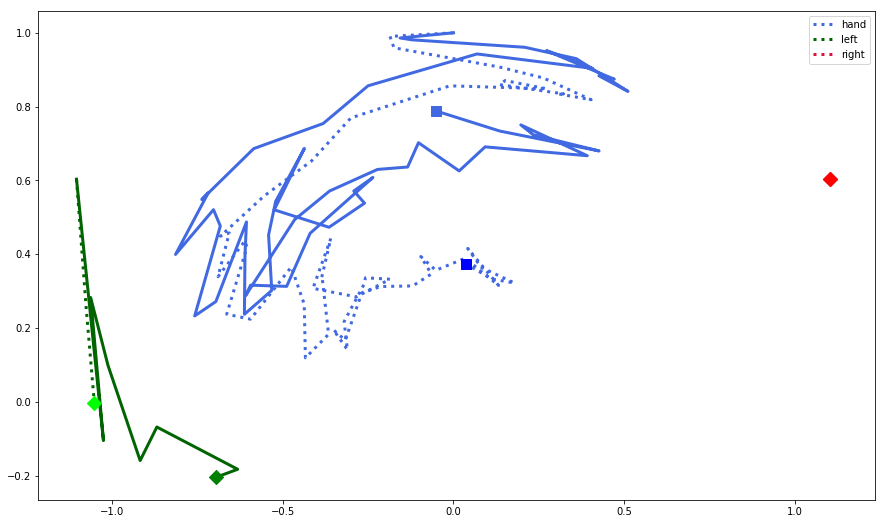

In [37]:
plot_traj(subdirs[0][0],j=4,Tmax=51,pred_type=1, eval_type=1)

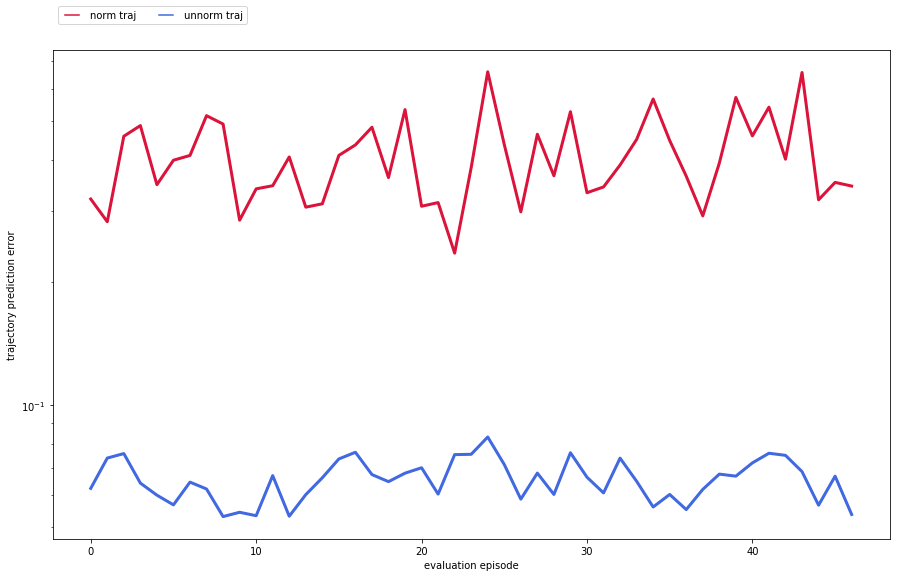

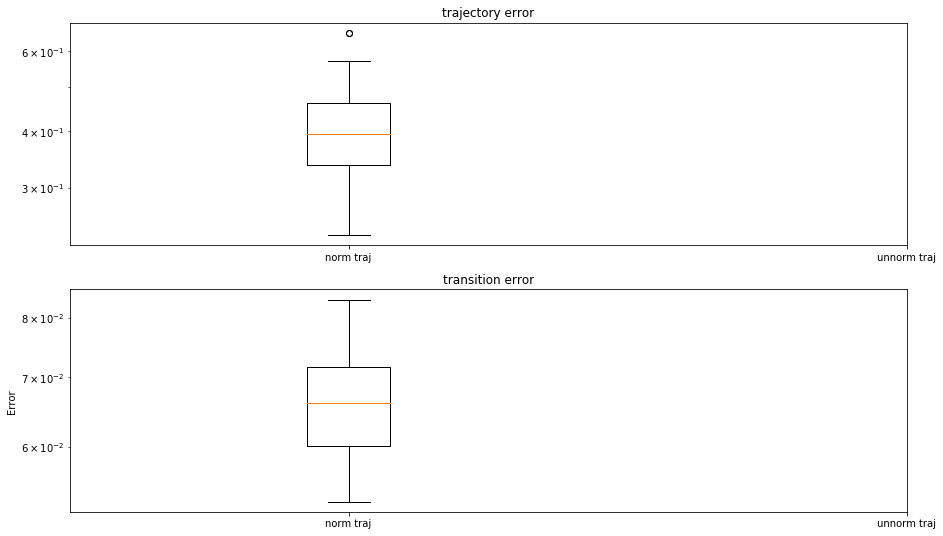

In [252]:
plot_episodes_errors(subdirs,names,np.mean,0)

# Select training samples

In [10]:
filename = "/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToy_random_train.pk"
with open(filename, 'br') as f:
    [true_traj,Acs] = pickle.load(f)
true_traj = np.array(true_traj)

In [11]:
np.shape(true_traj)

(1000, 51, 36)

[10, 14, 15, 18, 19, 25, 26, 31, 36, 40, 41, 45, 69, 94, 97, 100, 105, 119, 133, 137, 146, 149, 159, 166, 172, 177, 178, 186, 187, 189, 192, 197, 199, 204, 207, 212, 215, 217, 222, 225, 239, 242, 260, 261, 262, 264, 271, 272, 284, 293, 304, 308, 315, 316, 318, 327, 331, 333, 335, 336, 337, 352, 363, 365, 372, 374, 376, 377, 378, 384, 390, 393, 396, 400, 409, 414, 417, 418, 424, 428, 437, 439, 447, 463, 465, 468, 469, 470, 471, 474, 476, 477, 481, 482, 485, 488, 499, 501, 502, 508, 514, 519, 523, 524, 528, 543, 545, 552, 557, 564, 568, 569, 592, 613, 625, 629, 630, 632, 643, 644, 648, 662, 666, 667, 671, 681, 684, 687, 693, 699, 706, 711, 733, 740, 751, 754, 761, 762, 765, 768, 772, 779, 781, 782, 786, 789, 793, 796, 797, 801, 802, 803, 813, 819, 820, 824, 825, 826, 829, 833, 837, 841, 842, 847, 848, 861, 865, 867, 873, 878, 880, 884, 886, 892, 897, 905, 912, 921, 937, 944, 949, 952, 957, 968, 973, 975, 979, 987, 993, 999]


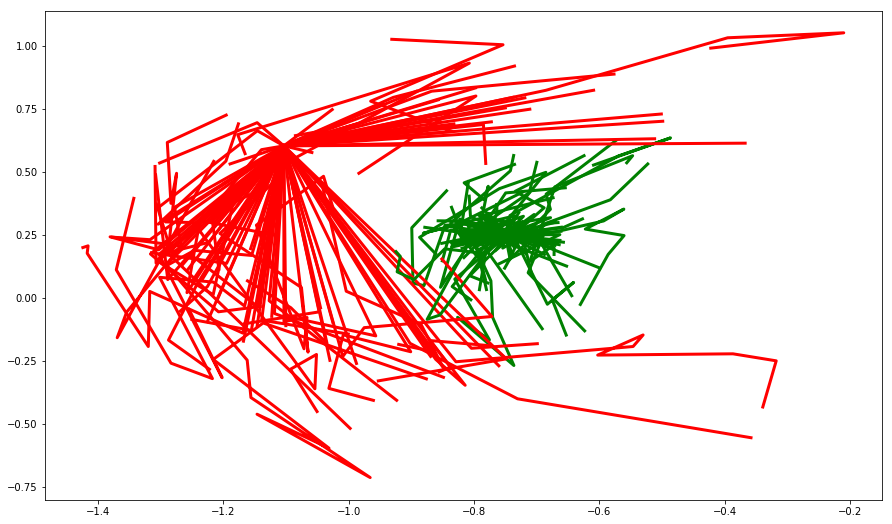

In [12]:
fig, ax = plt.subplots(figsize=FIGSIZE) 
idx = []
for j in range(len(true_traj)):
    #plt.plot(true_traj[j,:,0],true_traj[j,:,1], c="royalblue", lw=3 )
    if np.linalg.norm(true_traj[j,-1,24:]) > 0:
        idx.append(j)
        plt.plot(true_traj[j,:,6],true_traj[j,:,7], c="green", lw=3 )
        plt.plot(true_traj[j,:,8],true_traj[j,:,9], c="red", lw=3 )
print(idx)

In [13]:
pertinent_traj, actions = [], []
for j in range(len(true_traj)):
    if j in idx:
        pertinent_traj.append(true_traj[j])
        actions.append(Acs[j])
        

In [14]:
filename = "/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToy_onlypertinentfromrandom_train.pk"
with open(filename, 'bw') as f:
    pickle.dump([pertinent_traj,actions],f)

## Add noise

In [216]:
filename = "/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToy_pertinentfromrandom_train.pk"
with open(filename, 'br') as f:
    [traj,acs] = pickle.load(f)

pertinent_traj = np.array(traj)
for _ in range(4):
    pertinent_traj = np.concatenate((pertinent_traj, np.array(traj) + np.random.normal(0,0.01,np.shape(np.array(traj)))))

filename = "/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToy_pertinentfromrandom_noise01_train.pk"
with open(filename, 'bw') as f:
    pickle.dump([pertinent_traj,acs*5],f)

# Truc

In [230]:
[i*47 for i in range(5)]

[0, 47, 94, 141, 188]